In [25]:
import pandas as pd
import numpy as np
import nltk
import re
import os
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Data Generation and Preprocessing

In [2]:
if not os.path.exists('X_train.npy'):
    df = pd.read_csv('AI_Human.csv')

    X = df['text'].values
    y = df['generated'].values

    # discarding 90% of the data
    X, _, y, _ = train_test_split(X, y, test_size=0.9, random_state=42)

    # lowercase all words
    X = [word.lower() for word in tqdm(X)]

    # remove newline characters
    X = [word.replace("\n", "") for word in tqdm(X)]

    # remove punctuation and numbers
    X = [re.sub(r'[^a-zA-Z\s]', '', word) for word in tqdm(X)]

    class Lemmatizer:
        """Removes stopwords and performs lemmatization."""
        def __init__(self):
            self.lemmatizer = WordNetLemmatizer()
            self.stopwords = set(stopwords.words('english'))

        def lemmatize(self, sentence: str) -> str:
            """Given a sentence, removes stopwords and performs lemmatization."""
            words = nltk.word_tokenize(sentence)
            filtered_words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stopwords]
            return ' '.join(filtered_words)

    lemmatizer = Lemmatizer()
    X = [lemmatizer.lemmatize(word) for word in tqdm(X)]

    X = np.asarray(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

    np.save('X_train.npy', X_resampled)
    np.save('y_train.npy', y_resampled)
    np.save('X_test.npy', X_test)
    np.save('y_test.npy', y_test)
else:
    print('Found X_train, X_test, y_train, y_test numpy files!')

Found X_train, X_test, y_train, y_test numpy files!


In [3]:
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)

with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)

with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)

with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)

# Fine-Tuning BERT For AI/Human Text Classification

In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.utils.rnn import pad_sequence

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Freeze BERT model parameters
for param in model.bert.parameters():
    param.requires_grad = False

In [8]:
from torch.utils.data import Dataset, DataLoader

class BERTSentimentDataset(Dataset):
    """Dataset for fine-tuning BERT for sentiment classification."""
    def __init__(self, tokenizer, sentences, labels):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.labels = labels
    
    def __getitem__(self, idx):
        """
        Returns a dictionary with the following keys:
        - input_ids
        - token_type_ids
        - attention_mask
        - label
        """
        encoded_sentence = self.tokenizer(self.sentences[idx], truncation=True)
        encoded_sentence['label'] = self.labels[idx]
        return encoded_sentence
    
    def __len__(self):
        return len(self.sentences)

In [9]:
def collate_fn(batch):
    """Collates each batch so that input ids and attention masks have 0 padding."""
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    labels = torch.tensor([item['label'] for item in batch])
    input_ids = pad_sequence(input_ids, batch_first=True)
    attention_mask = pad_sequence(attention_mask, batch_first=True)
    
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

In [11]:
if not os.path.exists('model_checkpoints/BERT_lr_0.002_bs_32_epoch_1.pt'):
    lr = 2e-3
    batch_size = 32
    optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=lr)

    train_dataset = BERTSentimentDataset(tokenizer=tokenizer, sentences=X_train.flatten().astype('object'), labels=y_train.astype(np.int64))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    test_dataset = BERTSentimentDataset(tokenizer=tokenizer, sentences=X_test.flatten().astype('object'), labels=y_test.astype(np.int64))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    model.classifier.train()
    model.bert.eval()

    num_epochs = 1
    model_checkpoint_interval = 3
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    progress_bar = tqdm(range(num_epochs * len(train_dataloader)), desc="Training")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_length = 0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()
            epoch_length += 1
            progress_bar.update(1)
            progress_bar.set_postfix({"Epoch": epoch+1, "Loss": epoch_loss / epoch_length})

        print(f"Epoch {epoch+1} Loss: {epoch_loss / epoch_length:.4f}")

    progress_bar.close()
else:
    model.load_state_dict(torch.load('model_checkpoints/BERT_lr_0.002_bs_32_epoch_1.pt'))
    print('Loaded model from checkpoint!')

Loaded model from checkpoint!


In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Evaluation Accuracy: {accuracy:.4f}")

Evaluation: 100%|██████████| 305/305 [14:26<00:00,  2.84s/it]

Evaluation Accuracy: 0.9085


In [23]:
model.eval()
y_preds = np.asarray([])

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        y_preds = np.append(y_preds, predictions.cpu().numpy())

Evaluation: 100%|██████████| 305/305 [11:43<00:00,  2.31s/it]


In [27]:
print(classification_report(y_true=y_test, y_pred=y_preds))

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      6143
         1.0       0.88      0.87      0.88      3602

    accuracy                           0.91      9745
   macro avg       0.90      0.90      0.90      9745
weighted avg       0.91      0.91      0.91      9745



In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train.flatten())

test_vectorizer = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)
X_test_tfidf = test_vectorizer.fit_transform(X_test.flatten())

In [14]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [17]:
print(classification_report(y_true=y_test, y_pred=lr_classifier.predict(X_test_tfidf)))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      6143
         1.0       0.97      0.98      0.98      3602

    accuracy                           0.98      9745
   macro avg       0.98      0.98      0.98      9745
weighted avg       0.98      0.98      0.98      9745



In [26]:
print(roc_auc_score(y_true=y_test, 
                    y_score=lr_classifier.predict_proba(X_test_tfidf)[:, 1], 
                    average='macro'))

0.9974788817650909


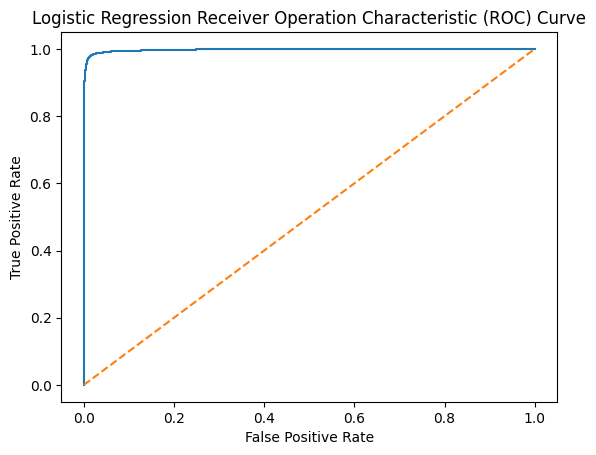

In [23]:
fpr_list, tpr_list, thresholds = roc_curve(y_true=y_test, 
                                           y_score=lr_classifier.predict_proba(X_test_tfidf)[:, 1])

plt.plot(fpr_list, tpr_list, label='Logistic Regression')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--')
plt.title('Logistic Regression Receiver Operation Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [19]:
def sort_indices_by_values(indices: np.array, values: np.array) -> np.array:
    """
    Given a list of indices A and a list of values B such that each element in A corresponds 
    to each element in B (i.e., A[0] -> B[0], A[1] -> B[1], ...), sorts the indices such that 
    the first index in the resulting list corresponds to the highest value. The second index in
    the resulting list corresponds to the second highest value, etc.
    """
    pairs = zip(indices, values)
    
    # Sort pairs based on values
    sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
    
    # Extract sorted indices
    sorted_indices = [pair[0] for pair in sorted_pairs]
    
    return sorted_indices

In [39]:
lr_classifier_coef = lr_classifier.coef_[0]
upper_threshold = 0.5
top_k = 40

indices = np.where(lr_classifier_coef > upper_threshold)[0]
values = lr_classifier_coef[lr_classifier_coef > upper_threshold] 

sorted_indices = sort_indices_by_values(indices, values)
print(f'Top {top_k} words that contributed towards a AI generated prediction:\n', 
      vectorizer.get_feature_names_out()[sorted_indices][:top_k])

Top 40 words that contributed towards a AI generated prediction:
 ['important' 'potential' 'additionally' 'provide' 'conclusion' 'super'
 'essay' 'reduce' 'lead' 'academic' 'support' 'like' 'youre' 'impact'
 'climate' 'number' 'ensure' 'significant' 'popular' 'however' 'focus'
 'cool' 'understanding' 'risk' 'consider' 'often' 'ensures' 'privacy'
 'hey' 'believe' 'health' 'concern' 'congestion' 'difference' 'difficult'
 'theyre' 'balance' 'argue' 'individual' 'essential']


In [41]:
lr_classifier_coef = lr_classifier.coef_[0]
lower_threshold = -0.5
top_k = 40

indices = np.where(lr_classifier_coef < lower_threshold)[0]
values = lr_classifier_coef[lr_classifier_coef < lower_threshold] 

sorted_indices = sort_indices_by_values(indices, values)[::-1] # reverse to get lowest value first
print(f'Top {top_k} words that contributed towards a human generated prediction:\n', 
      vectorizer.get_feature_names_out()[sorted_indices][:top_k])

Top 40 words that contributed towards a human generated prediction:
 ['would' 'go' 'people' 'elector' 'paragraph' 'student' 'percent' 'get'
 'many' 'going' 'voting' 'car' 'driving' 'nasa' 'person' 'although' 'said'
 'project' 'home' 'human' 'venus' 'show' 'smog' 'one' 'text' 'almost'
 'probably' 'picture' 'vote' 'kid' 'america' 'computer' 'alien' 'though'
 'want' 'emotion' 'say' 'school' 'another' 'earth']


In [28]:
lr_classifier = LogisticRegression(random_state=42, max_iter=1)
lr_classifier.fit(X_train_tfidf, y_train)

c:\Users\hkimr\anaconda3\envs\final_nlp_env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1, random_state=42)

In [29]:
print(classification_report(y_true=y_test, y_pred=lr_classifier.predict(X_test_tfidf)))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      6143
         1.0       0.99      0.59      0.74      3602

    accuracy                           0.84      9745
   macro avg       0.90      0.79      0.81      9745
weighted avg       0.87      0.84      0.83      9745

